# Machine Learning Engineer Nanodegree
## Capstone Project
Santiago Giraldo

July 29, 2017

Perhaps one of the trendiest topics in the world right now is machine learning and big data, which have become recurring topics on Main Street.  The application of these in different fields including branches of knowledge that range from astronomy to manufacturing, but perhaps the field of medicine is one the most interesting of them all.   Current advances in this field include disease diagnosis, image analysis, new drug developments and pandemic forecasts among others.   These progress poses new challenges and opportunities to improve the quality of treatments and the life expectancy of human beings. 

Being able to participate in something that contributes to human well-being motivated me to research and apply machine learning in an area of medicine to the capstone project.

From personal experience, a recurring problem that affects people at certain ages is pneumonia, which in some cases is usually fatal especially when it refers to children or older adults.   Knowing this and the availability of records in Intensive Care Unit MIMIC-III database, I decided to select pneumonia deaths as a theme to develop the capstone project, that in addition, could be useful for the prognosis of deaths in Intensive Care Units, and with further investigations be the outset for development of tools that doctors and nurses could use to improve their work.

The hypothesis is that from microbiological variables coming from tests it’s possible predict whether a patient can or not die by this disease.  This leads us to a problem that can be represented binarily, and that can be related to physicochemical variables obtained from microbiological tests. These relationships allow the modeling of the pneumonia death problem by means of a supervised learning model such as the Support Vector Machines, Decision Trees, Logistic Regression and Ada boost ensemble.

In [1]:
import numpy as np
import pandas as pd
import datetime
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import psycopg2
import time
import itertools
from pandas.io.sql import read_sql
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn import metrics

The MIMIC III database consists of a collection of csv files, which can be imported into PostgreSQL.  Once imported to PostgreSQL, is possible to use libraries from python to analyze the different data contained in it, make the necessary transformations to implement the desired forecast model.  The input variables will be defined from different tables and seeking relate the independent binary variable (life or death) of subjects with age, sex, results of microbiological events (test results) and severity of these results.

Before you can download the data, you must complete the CITI "Data or Specimens Only Research" course . Once you accomplish the course you can download the data from https://physionet.org/works/MIMICIIIClinicalDatabase/. Then, the first step was to understand the structure of the database. This consists of a collection of 26 csv files, which can be imported into PostgreSQL.  These files contain medical, economic, demographic and death of patients admitted information for several years at the ICU of Beth Israel Deaconess Medical Center, as the data is sensitive, some records were changed like date of admittance and date of birth, in order to avoid the identification of the patients from these records, and this information will be misused in the future.  


In [2]:
conn=psycopg2.connect(
    dbname='mimic',
    user='postgres',
    host='localhost',
    port=5432,
    password= 123
)
cur = conn.cursor()
process = time.process_time()
print (process)

4.609375


The first step was creating four tables to facilitate consult the required data for the analysis, these tables are: 

-	last_event:  This table born from a join of patients and admissions tables.  In this, was selected the fields subject_id, dob, and gender. The age is computed for all patients, the last admission column is created and all age are classified by age groups as categorical variable.


-	age: Is a join between last_event and admission tables.  In this, I selected the subject_id, last_admit_age, gender, last_admit_time, but the records are limited to last patient admission (there are records for several admissions for some patients, so is important filter the last one to related the records with deaths when these occur) computed in last_event table.


-	valuenum_avg:  In a first instance, I have grouped the 14 tables that have the data records of graphical events. As a group, it is the largest table in the database and it contains 330,712,483 records. Given the size of the data, hardware constraints, I considered a strong assumption, and is that the records in this table where the numerical value (valuenum) of these graphic events are measured, can be averaged (huge assumption) can serve as a numerical dependent variable within the models to be studied.  It is a huge assumption because I have no evidence from other studies, at least as far as I know, the results average can be done. But on the other hand, you can think by experience (as patient because I’m not physician), the results from exams are a good estimation, and the issue, at least for me, is if this data could be averaged as I did and if it could be a good proxy regressor.  For this table, I take this data: subject_id, hadm_id, itemid, and compute valuenum_avg.  


-	pneumonia: It is the most important table for this study because I group the relevant data from others tables like microbiology events, charted events, and demographic data.  The specific fields grouped here are: hospital_expire_flag, subject_id, hadm_id, gender, last_admittime, last_admit_age, age_group, itemid, label, category, valuenum_avg, icd9_code, short_title, spec_type_desc, org_name, ab_name, interpretation.  And this data where filtered by pneumonia word in long_title diagnosis field, values not null in interpretation in microbiology events, values not null in category laboratory items and admittime is equal to last_admittime.  The objective here is assuring me that data is complete (not null records), is related with pneumonia diagnosis and the records selected where from the last admission.

The final result of these process is a sql query which filter and transform the data in a matrix with this columns fields:  hospital_expire_flag, subject_id, gender, last_admit_age, age_group, category, label, valuenum_avg, org_name, ab_name, interpretation, and 2,430,640 records to 829 patients with some diagnosis related with pneumonia panda data frame


In [3]:
sql_sl = " SELECT hospital_expire_flag, subject_id, gender, last_admit_age, age_group, category, \
            label, valuenum_avg, org_name,ab_name, interpretation \
            FROM mimiciii.pneumonia;"

patients_pn= read_sql(sql_sl, conn, coerce_float=True, params=None)
print (patients_pn.info())
process = time.process_time()
print (process)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430640 entries, 0 to 2430639
Data columns (total 11 columns):
hospital_expire_flag    int64
subject_id              int64
gender                  object
last_admit_age          float64
age_group               object
category                object
label                   object
valuenum_avg            float64
org_name                object
ab_name                 object
interpretation          object
dtypes: float64(2), int64(2), object(7)
memory usage: 204.0+ MB
None
15.71875


For each subject, I categorized the population in five types of groups according to the age recorded at the time of admission to the ICU, which are neonates [0,1], middle (1, 14), adults (14, 65), Older adults [65, 85] and older elderly people (85, 91.4].    

In [4]:
patients_pn.head()

,hospital_expire_flag,subject_id,gender,last_admit_age,age_group,category,label,valuenum_avg,org_name,ab_name,interpretation
0,0,157,M,80.54,elderly,ABG,Arterial Base Excess,-3.75,STAPH AUREUS COAG +,TETRACYCLINE,S
1,0,157,M,80.54,elderly,ABG,Arterial Base Excess,-3.75,STAPH AUREUS COAG +,RIFAMPIN,S
2,0,157,M,80.54,elderly,ABG,Arterial Base Excess,-3.75,STAPH AUREUS COAG +,ERYTHROMYCIN,R
3,0,157,M,80.54,elderly,ABG,Arterial Base Excess,-3.75,STAPH AUREUS COAG +,GENTAMICIN,S
4,0,157,M,80.54,elderly,ABG,Arterial Base Excess,-3.75,STAPH AUREUS COAG +,VANCOMYCIN,S


In the Website  they explain that the average age of these patients is 91.4 years, reason why I decided that if I want have some consistent data from this segment of the population I should replace it at least for its average value

In [5]:
row_index = patients_pn.last_admit_age >= 300
patients_pn.loc[row_index , 'last_admit_age' ] = 91.4  #https://mimic.physionet.org/mimictables/patients/

- Hospital_expire_flag has the binary dependent variable to the model, 0 when the patient goes out from ICU alive, and 1 when the patient has deceased while stay in ICU.  


- Subject_id is the key value which relates the respective record with an acute patient in ICU.  gender give the patient sex of the subject.  Last_admit_age (is a computed field) has the age when the patient is admitted in ICU.


- Age_group (is a computed field) serves to categorize the sample by age.  


- Valuenum_avg is the average number for valuenum of this respective label measure.  Org_name contains the names of the microorganisms (bacteria) related to pneumonia, where the main ones are staph aureus coag +, klebsiella pneumoniae, escherichia coli, pseudomonas aeruginosa, staphylococcus, coagulase negative, klebsiella oxytoca, enterococcus sp, which represent 80% of the sample. 

- Category is employed to categorize the charted events, the main categories of this data column are Labs, Respiratory, Alarms, Routine Vital Signs, Chemistry which gathering the 82% of the records which are present in this query. 

In [6]:
patients_pn['category'].unique()

array(['ABG', 'Chemistry', 'Hematology', 'Coags', 'Enzymes', "ABG's",
       'Drug Level', 'Routine Vital Signs', 'Alarms', 'Respiratory',
       'Labs', 'General', 'Blood Gases', "VBG's", 'Skin - Impairment',
       "VBG'S", 'Mixed Venous Gases', 'Heme/Coag', 'Other ABGs', 'CSF',
       'Drug level', "ABG'S", 'Mixed VBGs', 'Urine', 'OT Notes',
       'Hemodynamics', 'Dialysis', 'Pain/Sedation', 'GI/GU', 'NICOM',
       'Cardiovascular (Pacer Data)', 'IABP', 'PiCCO', 'Adm History/FHPA',
       'Access Lines - Invasive', 'Treatments', 'Scores - APACHE IV (2)',
       'Scores - APACHE II', 'Venous ABG', 'Quick Admit', 'OB-GYN'], dtype=object)

In [7]:
patients_pn['category'].value_counts()

Labs                           951194
Respiratory                    538414
Alarms                         255555
Routine Vital Signs            157533
Chemistry                      106007
General                         87434
Skin - Impairment               56457
Hematology                      52049
Dialysis                        35259
Hemodynamics                    27275
ABG                             25475
Coags                           25359
Enzymes                         24121
OT Notes                        17580
Pain/Sedation                   10095
Drug Level                       8189
Cardiovascular (Pacer Data)      7590
Scores - APACHE IV (2)           7038
Scores - APACHE II               4950
ABG's                            3992
PiCCO                            3975
VBG's                            3528
NICOM                            3318
GI/GU                            2793
Blood Gases                      2782
IABP                             2150
Mixed Venous

In [8]:
patients_category = patients_pn['category'].value_counts().reset_index()
patients_category.columns=['category','Count']
patients_category['Count'].apply('{:,.2f}'.format)
patients_category['cum_perc'] = 100*patients_category.Count/patients_category.Count.sum()
patients_category['cum_perc'] = patients_category['cum_perc'].map('{:,.4f}%'.format)

print (patients_category)

                       category   Count  cum_perc
0                          Labs  951194  39.1335%
1                   Respiratory  538414  22.1511%
2                        Alarms  255555  10.5139%
3           Routine Vital Signs  157533   6.4811%
4                     Chemistry  106007   4.3613%
5                       General   87434   3.5972%
6             Skin - Impairment   56457   2.3227%
7                    Hematology   52049   2.1414%
8                      Dialysis   35259   1.4506%
9                  Hemodynamics   27275   1.1221%
10                          ABG   25475   1.0481%
11                        Coags   25359   1.0433%
12                      Enzymes   24121   0.9924%
13                     OT Notes   17580   0.7233%
14                Pain/Sedation   10095   0.4153%
15                   Drug Level    8189   0.3369%
16  Cardiovascular (Pacer Data)    7590   0.3123%
17       Scores - APACHE IV (2)    7038   0.2896%
18           Scores - APACHE II    4950   0.2037%


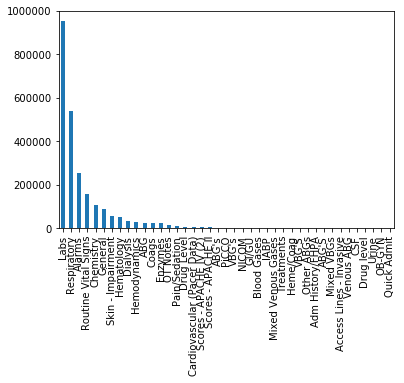

In [9]:
patients_pn['category'].value_counts().plot(kind='bar')

- Label is the detail of the category, and is represented in 578 labels, where the most important are: Hemoglobin Arterial Base Excess, Phosphorous, WBC, Creatinine, Magnesium, PTT, INR, ALT, AST, Lactic Acid. And the largest amount (Hemoglobin Arterial Base Excess) represents 0.94% of the sample and the lowest (Lactic Acid) 0.82% of the sample.

In [10]:
patients_pn['label'].unique()

array(['Arterial Base Excess', 'Arterial CO2(Calc)', 'Arterial PaCO2',
       'Arterial PaO2', 'Arterial pH', 'BUN (6-20)', 'Calcium (8.4-10.2)',
       'Carbon Dioxide', 'Chloride (100-112)', 'Creatinine (0-1.3)',
       'Differential-Bands', 'Differential-Basos', 'Differential-Eos',
       'Differential-Lymphs', 'Differential-Monos', 'Differential-Polys',
       'Fingerstick Glucose', 'Glucose (70-105)', 'Hematocrit',
       'Hemoglobin', 'INR (2-4 ref. range)', 'Ionized Calcium', 'LDH',
       'Lactic Acid(0.5-2.0)', 'Magnesium (1.6-2.6)', 'PT(11-13.5)',
       'PTT(22-35)', 'Phosphorous(2.7-4.5)', 'Platelets',
       'Potassium (3.5-5.3)', 'RBC', 'SaO2', 'Sodium (135-148)',
       'Vancomycin/Random', 'WBC (4-11,000)', 'Art.pH', 'WBC   (4-11,000)',
       'Calcium', 'Chloride', 'Creatinine', 'Glucose', 'INR',
       'Lactic Acid', 'Magnesium', 'PTT', 'Phosphorous', 'Potassium',
       'Sodium', 'WBC', 'Heart Rate', 'Heart rate Alarm - High',
       'Heart Rate Alarm - Low', 'Non In

In [11]:
patients_pn['label'].value_counts()

Hemoglobin                                22879
Arterial Base Excess                      21749
Phosphorous                               21579
WBC                                       21495
Creatinine                                21495
Magnesium                                 21474
PTT                                       21208
INR                                       21129
ALT                                       20185
AST                                       20172
Lactic Acid                               20031
Ionized Calcium                           19387
Differential-Monos                        19065
Differential-Lymphs                       19065
Differential-Eos                          19065
Differential-Basos                        19065
Albumin                                   18678
Hematocrit (serum)                        18412
Platelet Count                            18412
BUN                                       18412
Glucose (serum)                         

In [12]:
patients_label = patients_pn['label'].value_counts().reset_index()
patients_label.columns=['label','Count']
patients_label['Count'].apply('{:,.2f}'.format)
patients_label['cum_perc'] = 100*patients_label.Count/patients_label.Count.sum()
patients_label['cum_perc'] = patients_label['cum_perc'].map('{:,.4f}%'.format)

print (patients_label)

                                      label  Count cum_perc
0                                Hemoglobin  22879  0.9413%
1                      Arterial Base Excess  21749  0.8948%
2                               Phosphorous  21579  0.8878%
3                                       WBC  21495  0.8843%
4                                Creatinine  21495  0.8843%
5                                 Magnesium  21474  0.8835%
6                                       PTT  21208  0.8725%
7                                       INR  21129  0.8693%
8                                       ALT  20185  0.8304%
9                                       AST  20172  0.8299%
10                              Lactic Acid  20031  0.8241%
11                          Ionized Calcium  19387  0.7976%
12                       Differential-Monos  19065  0.7844%
13                      Differential-Lymphs  19065  0.7844%
14                         Differential-Eos  19065  0.7844%
15                       Differential-Ba

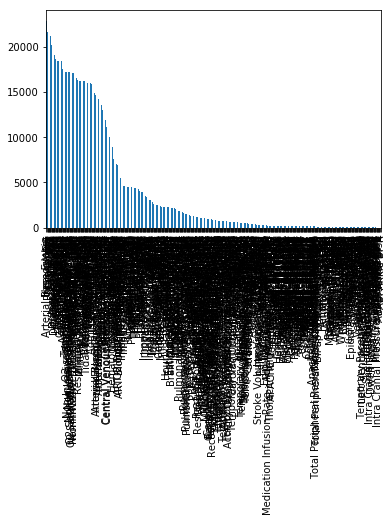

In [13]:
patients_pn['label'].value_counts().plot(kind='bar')

- Ab_name indicates which antibiotic is sensitive the microorganism, this field together with the interpretation indicates if the microorganism the degree of resistance of this one to the antibiotic., the main antibiotics evaluated are gentamicin, trimethoprim/sulfa, levofloxacin, ceftazidime, tobramycin, cefepime, ciprofloxacin, meropenem, erythromycin, oxacillin, vancomycin, ceftriaxone, tetracycline, clindamycin, piperacillin/tazo, which represent 80% of the sample.

In [14]:
patients_pn['ab_name'].unique()

array(['TETRACYCLINE', 'RIFAMPIN', 'ERYTHROMYCIN', 'GENTAMICIN',
       'VANCOMYCIN', 'OXACILLIN', 'LEVOFLOXACIN', 'PENICILLIN',
       'AMPICILLIN', 'NITROFURANTOIN', 'LINEZOLID', 'CEFTAZIDIME',
       'TOBRAMYCIN', 'CEFAZOLIN', 'CEFTRIAXONE', 'CIPROFLOXACIN',
       'AMPICILLIN/SULBACTAM', 'PIPERACILLIN/TAZO', 'CEFEPIME',
       'MEROPENEM', 'TRIMETHOPRIM/SULFA', 'CEFUROXIME', 'AMIKACIN',
       'PIPERACILLIN', 'CHLORAMPHENICOL', 'CLINDAMYCIN', 'IMIPENEM',
       'DAPTOMYCIN', 'PENICILLIN G'], dtype=object)

In [15]:
patients_pn['ab_name'].value_counts()

GENTAMICIN              250109
TRIMETHOPRIM/SULFA      196366
LEVOFLOXACIN            140174
CEFTAZIDIME             136404
TOBRAMYCIN              132454
CEFEPIME                130684
CIPROFLOXACIN           130334
MEROPENEM               126236
ERYTHROMYCIN            119631
OXACILLIN               118439
VANCOMYCIN              106293
CEFTRIAXONE              95930
TETRACYCLINE             92353
CLINDAMYCIN              92223
PIPERACILLIN/TAZO        91957
RIFAMPIN                 73251
AMPICILLIN/SULBACTAM     72894
CEFAZOLIN                65303
AMPICILLIN               50295
PENICILLIN G             38486
PIPERACILLIN             31307
NITROFURANTOIN           28717
CEFUROXIME               28239
AMIKACIN                 23785
PENICILLIN               20394
IMIPENEM                 17084
LINEZOLID                14807
DAPTOMYCIN                5239
CHLORAMPHENICOL           1252
Name: ab_name, dtype: int64

In [16]:
patients_ab_name = patients_pn['ab_name'].value_counts().reset_index()
patients_ab_name.columns=['ab_name','Count']
patients_ab_name['Count'].apply('{:,.2f}'.format)
patients_ab_name['cum_perc'] = 100*patients_ab_name.Count/patients_ab_name.Count.sum()
patients_ab_name['cum_perc'] = patients_ab_name ['cum_perc'].map('{:,.4f}%'.format)

print (patients_ab_name)

                 ab_name   Count  cum_perc
0             GENTAMICIN  250109  10.2898%
1     TRIMETHOPRIM/SULFA  196366   8.0788%
2           LEVOFLOXACIN  140174   5.7670%
3            CEFTAZIDIME  136404   5.6119%
4             TOBRAMYCIN  132454   5.4493%
5               CEFEPIME  130684   5.3765%
6          CIPROFLOXACIN  130334   5.3621%
7              MEROPENEM  126236   5.1935%
8           ERYTHROMYCIN  119631   4.9218%
9              OXACILLIN  118439   4.8727%
10            VANCOMYCIN  106293   4.3730%
11           CEFTRIAXONE   95930   3.9467%
12          TETRACYCLINE   92353   3.7995%
13           CLINDAMYCIN   92223   3.7942%
14     PIPERACILLIN/TAZO   91957   3.7832%
15              RIFAMPIN   73251   3.0137%
16  AMPICILLIN/SULBACTAM   72894   2.9990%
17             CEFAZOLIN   65303   2.6867%
18            AMPICILLIN   50295   2.0692%
19          PENICILLIN G   38486   1.5834%
20          PIPERACILLIN   31307   1.2880%
21        NITROFURANTOIN   28717   1.1815%
22         

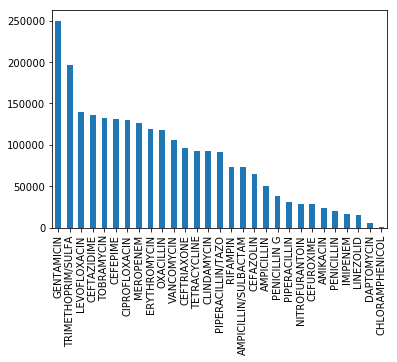

In [17]:
patients_pn['ab_name'].value_counts().plot(kind='bar')

- org_name has the microorganisms name are present in pneumonia patients.  The main organims found in this patients are staph aureus coag +, klebsiella pneumoniae, escherichia coli, pseudomonas aeruginosa, staphylococcus, coagulase negative, klebsiella oxytoca, enterococcus sp., acinetobacter baumannii complex, serratia marcescens, enterobacter cloacae.

In [18]:
patients_pn['org_name'].unique()

array(['STAPH AUREUS COAG +', 'ENTEROCOCCUS SP.', 'KLEBSIELLA PNEUMONIAE',
       'ESCHERICHIA COLI', 'ENTEROCOCCUS FAECIUM',
       'STAPHYLOCOCCUS, COAGULASE NEGATIVE',
       'STENOTROPHOMONAS (XANTHOMONAS) MALTOPHILIA',
       'ACINETOBACTER BAUMANNII', 'STREPTOCOCCUS PNEUMONIAE',
       'PSEUDOMONAS AERUGINOSA', 'ENTEROCOCCUS FAECALIS',
       'ENTEROBACTER CLOACAE', 'NON-FERMENTER, NOT PSEUDOMONAS AERUGINOSA',
       'KLEBSIELLA OXYTOCA', 'KLEBSIELLA SPECIES', 'PROTEUS MIRABILIS',
       'ENTEROBACTER AEROGENES', 'SERRATIA MARCESCENS',
       'CITROBACTER KOSERI', 'ACINETOBACTER BAUMANNII COMPLEX',
       'CITROBACTER FREUNDII COMPLEX', 'GRAM NEGATIVE ROD #2',
       'POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS',
       'BURKHOLDERIA (PSEUDOMONAS) CEPACIA', 'HAFNIA ALVEI',
       'MORGANELLA MORGANII', 'PROTEUS VULGARIS', 'CITROBACTER SPECIES',
       'STAPHYLOCOCCUS HOMINIS', 'ENTEROBACTER ASBURIAE',
       'STREPTOCOCCUS ANGINOSUS (MILLERI) GROUP',
       'BURKHOLDERIA CEPA

In [19]:
patients_pn['org_name'].value_counts()

STAPH AUREUS COAG +                                758120
KLEBSIELLA PNEUMONIAE                              369507
ESCHERICHIA COLI                                   304936
PSEUDOMONAS AERUGINOSA                             251556
STAPHYLOCOCCUS, COAGULASE NEGATIVE                 123864
KLEBSIELLA OXYTOCA                                  78064
ENTEROCOCCUS SP.                                    66151
ACINETOBACTER BAUMANNII COMPLEX                     59623
SERRATIA MARCESCENS                                 59299
ENTEROBACTER CLOACAE                                56678
PROTEUS MIRABILIS                                   38983
ENTEROBACTER AEROGENES                              38206
STREPTOCOCCUS PNEUMONIAE                            37870
NON-FERMENTER, NOT PSEUDOMONAS AERUGINOSA           28490
ENTEROCOCCUS FAECIUM                                26675
STENOTROPHOMONAS (XANTHOMONAS) MALTOPHILIA          16186
POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS     15453
CITROBACTER FR

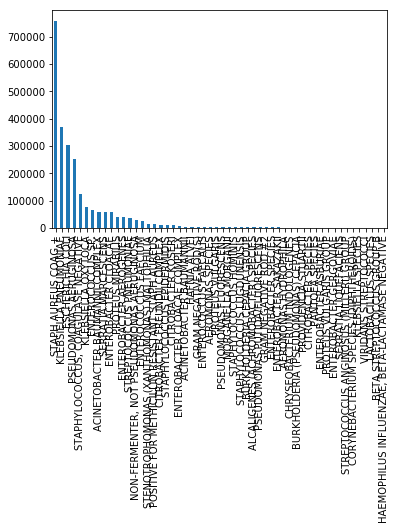

In [20]:
patients_pn['org_name'].value_counts().plot(kind='bar')

In [21]:
patients_org_name = patients_pn['org_name'].value_counts().reset_index()
patients_org_name.columns=['org_name','Count']
patients_org_name['Count'].apply('{:,.2f}'.format)
patients_org_name['cum_perc'] = 100*patients_org_name.Count/patients_org_name.Count.sum()
patients_org_name['cum_perc'] = patients_org_name['cum_perc'].map('{:,.4f}%'.format)

print (patients_org_name)

                                           org_name   Count  cum_perc
0                               STAPH AUREUS COAG +  758120  31.1901%
1                             KLEBSIELLA PNEUMONIAE  369507  15.2020%
2                                  ESCHERICHIA COLI  304936  12.5455%
3                            PSEUDOMONAS AERUGINOSA  251556  10.3494%
4                STAPHYLOCOCCUS, COAGULASE NEGATIVE  123864   5.0959%
5                                KLEBSIELLA OXYTOCA   78064   3.2117%
6                                  ENTEROCOCCUS SP.   66151   2.7215%
7                   ACINETOBACTER BAUMANNII COMPLEX   59623   2.4530%
8                               SERRATIA MARCESCENS   59299   2.4396%
9                              ENTEROBACTER CLOACAE   56678   2.3318%
10                                PROTEUS MIRABILIS   38983   1.6038%
11                           ENTEROBACTER AEROGENES   38206   1.5718%
12                         STREPTOCOCCUS PNEUMONIAE   37870   1.5580%
13        NON-FERMEN

-  interpretation indicates the results of the test,  “S” when the antibiotic is sensitive, “R” when is resistant, “I” when the antibiotic is intermediate, and “P” when is pending.

In [22]:
patients_pn['interpretation'].unique()

array(['S', 'R', 'I', 'P'], dtype=object)

In [23]:
patients_pn['interpretation'].value_counts()

S    1617210
R     732254
I      81132
P         44
Name: interpretation, dtype: int64

In [24]:
patients_interpretation = patients_pn['interpretation'].value_counts().reset_index()
patients_interpretation.columns=['interpretation','Count']
patients_interpretation['Count'].apply('{:,.2f}'.format)
patients_interpretation['cum_perc'] = 100*patients_interpretation.Count/patients_interpretation.Count.sum()
patients_interpretation['cum_perc'] = patients_interpretation ['cum_perc'].map('{:,.4f}%'.format)

print (patients_interpretation)

  interpretation    Count  cum_perc
0              S  1617210  66.5343%
1              R   732254  30.1260%
2              I    81132   3.3379%
3              P       44   0.0018%


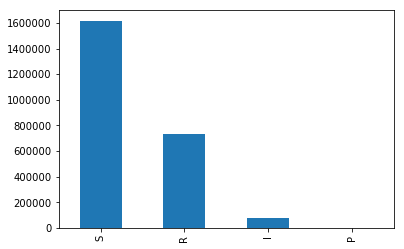

In [25]:
patients_pn['interpretation'].value_counts().plot(kind='bar')

In [26]:
patients_pn.head()

,hospital_expire_flag,subject_id,gender,last_admit_age,age_group,category,label,valuenum_avg,org_name,ab_name,interpretation
0,0,157,M,80.54,elderly,ABG,Arterial Base Excess,-3.75,STAPH AUREUS COAG +,TETRACYCLINE,S
1,0,157,M,80.54,elderly,ABG,Arterial Base Excess,-3.75,STAPH AUREUS COAG +,RIFAMPIN,S
2,0,157,M,80.54,elderly,ABG,Arterial Base Excess,-3.75,STAPH AUREUS COAG +,ERYTHROMYCIN,R
3,0,157,M,80.54,elderly,ABG,Arterial Base Excess,-3.75,STAPH AUREUS COAG +,GENTAMICIN,S
4,0,157,M,80.54,elderly,ABG,Arterial Base Excess,-3.75,STAPH AUREUS COAG +,VANCOMYCIN,S


To transform the matrix in a pivot table, the first step is transform some categorical variables as dummy variables.  The chosen variables are gender, age_group, category, label, org_name, ab_name, and interpretation.  This operation was done with pandas get_dummies command.  The result of this transformation is a panda data frame with shape 2,430,640 rows by 716 columns, these new columns are binaries variables and only take the number 1 once the categorical effect happened.

In [27]:
patients_dummy = pd.get_dummies(patients_pn,prefix=['gender', 'age_group', 'category','label', 
                                                    'org_name','ab_name', 'interpretation'])
patients_dummy.head() 

,hospital_expire_flag,subject_id,last_admit_age,valuenum_avg,gender_F,gender_M,age_group_adult,age_group_elderly,age_group_neonate,age_group_oldest old,...,ab_name_PIPERACILLIN/TAZO,ab_name_RIFAMPIN,ab_name_TETRACYCLINE,ab_name_TOBRAMYCIN,ab_name_TRIMETHOPRIM/SULFA,ab_name_VANCOMYCIN,interpretation_I,interpretation_P,interpretation_R,interpretation_S
0,0,157,80.54,-3.75,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,157,80.54,-3.75,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,157,80.54,-3.75,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,157,80.54,-3.75,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,157,80.54,-3.75,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


The next step, is to transform the matrix into a PivotTable, the purpose of this transformation is to be able to have the medical data in individual lines per subject and numerical form.  
To do that, I employed pandas pivot_table command, and using as indexes subject_id and hospital_expire_flag.  With this transformation, the resulting panda data frame has 829 rows by 724 columns.  The data transformed in this form allow apply the classifier models to this data.

In [28]:
patients_data = pd.pivot_table(patients_dummy,index=["subject_id", "hospital_expire_flag" ])
process = time.process_time()
print (process)

184.25


In [29]:
patients_data.head()

,,ab_name_AMIKACIN,ab_name_AMPICILLIN,ab_name_AMPICILLIN/SULBACTAM,ab_name_CEFAZOLIN,ab_name_CEFEPIME,ab_name_CEFTAZIDIME,ab_name_CEFTRIAXONE,ab_name_CEFUROXIME,ab_name_CHLORAMPHENICOL,ab_name_CIPROFLOXACIN,...,org_name_STAPH AUREUS COAG +,org_name_STAPHYLOCOCCUS EPIDERMIDIS,org_name_STAPHYLOCOCCUS HOMINIS,org_name_STAPHYLOCOCCUS LUGDUNENSIS,"org_name_STAPHYLOCOCCUS, COAGULASE NEGATIVE",org_name_STENOTROPHOMONAS (XANTHOMONAS) MALTOPHILIA,org_name_STREPTOCOCCUS ANGINOSUS (MILLERI) GROUP,org_name_STREPTOCOCCUS PNEUMONIAE,org_name_VIRIDANS STREPTOCOCCI,valuenum_avg
subject_id,hospital_expire_flag,,,,,,,,,,,,,,,,,,,,,
41,0,0.0,0.018182,0.036364,0.036364,0.036364,0.036364,0.036364,0.036364,0.0,0.018182,...,0.236364,0.0,0.0,0,0.163636,0.072727,0.0,0.0,0,36.219025
157,0,0.0,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.615385,0.0,0.0,0,0.000000,0.000000,0.0,0.0,0,44.302839
177,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,0.0,0.0,0,0.000000,0.000000,0.0,0.0,0,39.911055
203,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,0.0,0.0,0,0.000000,0.000000,0.0,0.0,0,53.690473
236,0,0.0,0.000000,0.090909,0.090909,0.090909,0.090909,0.090909,0.000000,0.0,0.090909,...,0.000000,0.0,0.0,0,0.000000,0.000000,0.0,0.0,0,69.293584


In [30]:
patients_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 829 entries, (41, 0) to (99985, 0)
Columns: 714 entries, ab_name_AMIKACIN to valuenum_avg
dtypes: float64(703), uint8(11)
memory usage: 4.5+ MB


In [31]:
patients = patients_data.reset_index()

In [32]:
patients.head()

,subject_id,hospital_expire_flag,ab_name_AMIKACIN,ab_name_AMPICILLIN,ab_name_AMPICILLIN/SULBACTAM,ab_name_CEFAZOLIN,ab_name_CEFEPIME,ab_name_CEFTAZIDIME,ab_name_CEFTRIAXONE,ab_name_CEFUROXIME,...,org_name_STAPH AUREUS COAG +,org_name_STAPHYLOCOCCUS EPIDERMIDIS,org_name_STAPHYLOCOCCUS HOMINIS,org_name_STAPHYLOCOCCUS LUGDUNENSIS,"org_name_STAPHYLOCOCCUS, COAGULASE NEGATIVE",org_name_STENOTROPHOMONAS (XANTHOMONAS) MALTOPHILIA,org_name_STREPTOCOCCUS ANGINOSUS (MILLERI) GROUP,org_name_STREPTOCOCCUS PNEUMONIAE,org_name_VIRIDANS STREPTOCOCCI,valuenum_avg
0,41,0,0.0,0.018182,0.036364,0.036364,0.036364,0.036364,0.036364,0.036364,...,0.236364,0.0,0.0,0,0.163636,0.072727,0.0,0.0,0,36.219025
1,157,0,0.0,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.615385,0.0,0.0,0,0.000000,0.000000,0.0,0.0,0,44.302839
2,177,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,0.0,0,0.000000,0.000000,0.0,0.0,0,39.911055
3,203,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,0.0,0,0.000000,0.000000,0.0,0.0,0,53.690473
4,236,0,0.0,0.000000,0.090909,0.090909,0.090909,0.090909,0.090909,0.000000,...,0.000000,0.0,0.0,0,0.000000,0.000000,0.0,0.0,0,69.293584


In [33]:
p_data= patients.ix[:,2:]

In [34]:
p_data.head()

,ab_name_AMIKACIN,ab_name_AMPICILLIN,ab_name_AMPICILLIN/SULBACTAM,ab_name_CEFAZOLIN,ab_name_CEFEPIME,ab_name_CEFTAZIDIME,ab_name_CEFTRIAXONE,ab_name_CEFUROXIME,ab_name_CHLORAMPHENICOL,ab_name_CIPROFLOXACIN,...,org_name_STAPH AUREUS COAG +,org_name_STAPHYLOCOCCUS EPIDERMIDIS,org_name_STAPHYLOCOCCUS HOMINIS,org_name_STAPHYLOCOCCUS LUGDUNENSIS,"org_name_STAPHYLOCOCCUS, COAGULASE NEGATIVE",org_name_STENOTROPHOMONAS (XANTHOMONAS) MALTOPHILIA,org_name_STREPTOCOCCUS ANGINOSUS (MILLERI) GROUP,org_name_STREPTOCOCCUS PNEUMONIAE,org_name_VIRIDANS STREPTOCOCCI,valuenum_avg
0,0.0,0.018182,0.036364,0.036364,0.036364,0.036364,0.036364,0.036364,0.0,0.018182,...,0.236364,0.0,0.0,0,0.163636,0.072727,0.0,0.0,0,36.219025
1,0.0,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.615385,0.0,0.0,0,0.000000,0.000000,0.0,0.0,0,44.302839
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,0.0,0.0,0,0.000000,0.000000,0.0,0.0,0,39.911055
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,0.0,0.0,0,0.000000,0.000000,0.0,0.0,0,53.690473
4,0.0,0.000000,0.090909,0.090909,0.090909,0.090909,0.090909,0.000000,0.0,0.090909,...,0.000000,0.0,0.0,0,0.000000,0.000000,0.0,0.0,0,69.293584


In [35]:
p_target= patients['hospital_expire_flag']

In [36]:
p_target.head()

0    0
1    0
2    0
3    0
4    0
Name: hospital_expire_flag, dtype: int64

In all models, the variable dependent is survival state (Alive / Deceased).   In order to sub-setting the data I work with a test size of 25% of the sample, I chose this value after some essays, a higher percentage could lower the computer velocity, and a higher value could make the results will be spurious or meaningless.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    p_data, p_target, test_size=0.25, random_state=123)

In [38]:
X_train.head()

,ab_name_AMIKACIN,ab_name_AMPICILLIN,ab_name_AMPICILLIN/SULBACTAM,ab_name_CEFAZOLIN,ab_name_CEFEPIME,ab_name_CEFTAZIDIME,ab_name_CEFTRIAXONE,ab_name_CEFUROXIME,ab_name_CHLORAMPHENICOL,ab_name_CIPROFLOXACIN,...,org_name_STAPH AUREUS COAG +,org_name_STAPHYLOCOCCUS EPIDERMIDIS,org_name_STAPHYLOCOCCUS HOMINIS,org_name_STAPHYLOCOCCUS LUGDUNENSIS,"org_name_STAPHYLOCOCCUS, COAGULASE NEGATIVE",org_name_STENOTROPHOMONAS (XANTHOMONAS) MALTOPHILIA,org_name_STREPTOCOCCUS ANGINOSUS (MILLERI) GROUP,org_name_STREPTOCOCCUS PNEUMONIAE,org_name_VIRIDANS STREPTOCOCCI,valuenum_avg
121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,1.000000,0.0,0.0,0,0.000000,0.0,0.0,0.000000,0,42.223256
498,0.000000,0.022222,0.022222,0.022222,0.088889,0.088889,0.088889,0.0,0.0,0.088889,...,0.155556,0.0,0.0,0,0.000000,0.0,0.0,0.044444,0,233.596849
161,0.000000,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.0,0.0,0.035714,...,0.535714,0.0,0.0,0,0.000000,0.0,0.0,0.000000,0,320.200094
512,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.0,0.0,0.076923,...,0.000000,0.0,0.0,0,0.000000,0.0,0.0,0.000000,0,62.870238
209,0.000000,0.000000,0.000000,0.000000,0.098592,0.098592,0.000000,0.0,0.0,0.098592,...,0.084507,0.0,0.0,0,0.126761,0.0,0.0,0.000000,0,110.258445


In [39]:
X_train.shape, y_train.shape

((621, 714), (621,))

In [40]:
X_test.shape, y_test.shape

((208, 714), (208,))

-	Support Vector Machine:  Machine Support Vector (SVM) is a classification method that separates a sample points in different hyperplanes in multidimensional spaces, which are separated by different labels. The algorithm seeks to group the data (classify) by optimal search (minimum distance) between the hyperplanes, the resulting vectors are called support vectors .   The optimization is made over kernels (mathematical functions), in this analysis I used different methods: linear, radial basis function (rbf) and sigmoid.  I purposely avoided using the polynomial kernels, more because of parameterization problems that did not allow me to run the data with this algorithm.  

In [41]:
# the same model as above, only has changed the jobs

clf_SVC = SVC(kernel='linear', C=1)
scores_SVC = cross_val_score(clf_SVC, X_train, y_train, cv=4, n_jobs=-1)
print(scores_SVC)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_SVC.mean(), scores_SVC.std() * 2))
clf_SVC = clf_SVC.fit(X_train, y_train)
y_predicted_SVC = clf_SVC.predict(X_test)

print (metrics.classification_report(y_test, y_predicted_SVC))

process = time.process_time()
print (process)

[ 0.72435897  0.71612903  0.70322581  0.72258065]
Accuracy: 0.7166 (+/- 0.0166)
             precision    recall  f1-score   support

          0       0.74      1.00      0.85       154
          1       0.00      0.00      0.00        54

avg / total       0.55      0.74      0.63       208

308.734375


C:\Users\pc1\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


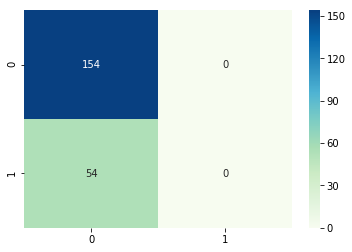

In [42]:
sns.heatmap(confusion_matrix(y_test, y_predicted_SVC), annot = True, fmt = '', cmap = "GnBu")

In [43]:
print ("Fitting the Support Vector Classification - kernel Radial Basis Function classifier to the training set")

param_grid = {
          'C': [1e-3, 1e-2, 1, 1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf_RBF = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', cache_size=1000), param_grid)
clf_RBF = clf_RBF.fit(X_train, y_train)

scores_RBF = cross_val_score(clf_RBF, X_train, y_train, cv=4, n_jobs=-1)
print(scores_RBF)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RBF.mean(), scores_RBF.std() * 2))
print ("Best estimator found by grid search:")
print (clf_RBF.best_estimator_)

y_predicted_RBF = clf_RBF.predict(X_test)

print (metrics.classification_report(y_test, y_predicted_RBF))

process = time.process_time()
print (process)

Fitting the Support Vector Classification - kernel Radial Basis Function classifier to the training set
[ 0.71794872  0.72258065  0.72258065  0.72258065]
Accuracy: 0.72 (+/- 0.00)
Best estimator found by grid search:
SVC(C=1, cache_size=1000, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
             precision    recall  f1-score   support

          0       0.75      0.99      0.85       154
          1       0.50      0.04      0.07        54

avg / total       0.68      0.74      0.65       208

405.6875


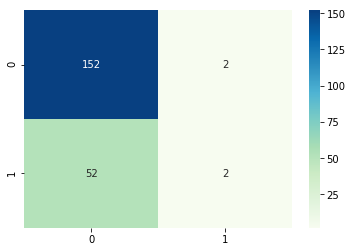

In [44]:
sns.heatmap(confusion_matrix(y_test, y_predicted_RBF), annot = True, fmt = '', cmap = "GnBu")

In [45]:
# Mimic-iii_Model-Pulmonary.ipynb
print ("Fitting the Linear Support Vector Classification - Hingue loss classifier to the training set")

param_grid = {
         'C': [1e-3, 1e-2, 1, 1e3, 5e3, 1e4, 5e4, 1e5],
          #'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf_LSCV = GridSearchCV(LinearSVC(C=1, loss= 'hinge'), param_grid, n_jobs=-1)
clf_LSCV = clf_LSCV.fit(X_train, y_train)

scores_LSCV = cross_val_score(clf_LSCV, X_train, y_train, cv=4, n_jobs=-1)
print(scores_LSCV)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_LSCV.mean(), scores_LSCV.std() * 2))

print ("Best estimator found by grid search:")
print (clf_LSCV.best_estimator_)

y_predicted_LSCV = clf_LSCV.predict(X_test)

print (metrics.classification_report(y_test, y_predicted_LSCV))

process = time.process_time()
print (process)

Fitting the Linear Support Vector Classification - Hingue loss classifier to the training set
[ 0.72435897  0.72258065  0.72258065  0.72258065]
Accuracy: 0.7230 (+/- 0.0015)
Best estimator found by grid search:
LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
             precision    recall  f1-score   support

          0       0.74      1.00      0.85       154
          1       0.00      0.00      0.00        54

avg / total       0.55      0.74      0.63       208

406.53125


C:\Users\pc1\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


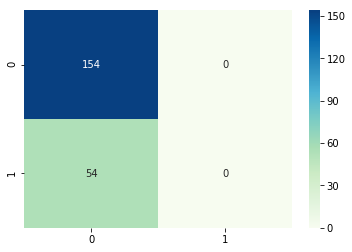

In [46]:
sns.heatmap(confusion_matrix(y_test, y_predicted_LSCV), annot = True, fmt = '', cmap = "GnBu")

- I was struggling a lot with this model, for that reason I will not use this for capstone project

print ("Fitting the classifier to the training set")
from sklearn.tree import DecisionTreeClassifier
param_grid = {
         'C': [1e-3, 1e-2, 1, 1e3, 5e3, 1e4, 5e4, 1e5],
         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1],
         'degree': [3,4,5]
          }
- for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'

clf_poly = GridSearchCV(SVC(kernel='poly', class_weight='balanced'), param_grid, n_jobs=-1)
clf_poly = clf_poly.fit(X_train, y_train)

scores_poly = cross_val_score(clf_poly, X_train, y_train, cv=4,n_jobs=-1)
print(scores_poly)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_poly.mean(), scores_poly.std() * 2))

print ("Best estimator found by grid search:")
print (clf_poly.best_estimator_)

y_predicted_poly = clf_poly.predict(X_test)

print (metrics.classification_report(y_test, y_predicted_poly))

process = time.process_time()
print (process)

In [47]:
print ("Fitting the Support Vector Classification - kernel Sigmoid classifier to the training set")

param_grid = {
         'C': [1e3, 1e4, 1e5],
         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1],
         'coef0':[-1,0,1]
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf_SIGMOID = GridSearchCV(SVC(kernel='sigmoid', class_weight='balanced'), param_grid, n_jobs=-1)
clf_SIGMOID = clf_SIGMOID.fit(X_train, y_train)

scores_SIGMOID = cross_val_score(clf_SIGMOID, X_train, y_train, cv=4, n_jobs=-1)
print(scores_SIGMOID)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_SIGMOID.mean(), scores_SIGMOID.std() * 2))

print ("Best estimator found by grid search:")
print (clf_SIGMOID.best_estimator_)

y_predicted_SIGMOID = clf_SIGMOID.predict(X_test)

print (metrics.classification_report(y_test, y_predicted_SIGMOID))

process = time.process_time()
print (process)

Fitting the Support Vector Classification - kernel Sigmoid classifier to the training set
[ 0.62179487  0.67096774  0.57419355  0.6       ]
Accuracy: 0.6167 (+/- 0.0711)
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=1,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
             precision    recall  f1-score   support

          0       0.72      0.68      0.70       154
          1       0.22      0.26      0.24        54

avg / total       0.59      0.57      0.58       208

409.609375


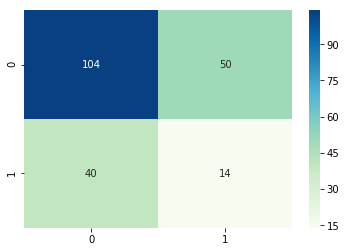

In [48]:
sns.heatmap(confusion_matrix(y_test, y_predicted_SIGMOID), annot = True, fmt = '', cmap = "GnBu")

- 	Decision Tree Classifier is a no parametric method that learns through binary decisions that when deployed are forming a decision tree.   

In [49]:
print ("Fitting the Decision Tree Classifier to the training set")

param_grid = {
         'max_depth': [2, 3, 4, 5, 6,7],
          #'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf_DTC = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=123, 
                       class_weight='balanced'), param_grid, n_jobs=-1)

clf_DTC = clf_DTC.fit(X_train, y_train)

scores_DTC = cross_val_score(clf_DTC, X_train, y_train, cv=4, n_jobs=-1)
print(scores_DTC)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_DTC.mean(), scores_DTC.std() * 2))

print ("Best estimator found by grid search:")
print (clf_DTC.best_estimator_)
y_predicted_DTC = clf_DTC.predict(X_test)

print (metrics.classification_report(y_test, y_predicted_DTC))
process = time.process_time()
print (process)


Fitting the Decision Tree Classifier to the training set
[ 0.60897436  0.6516129   0.61935484  0.70322581]
Accuracy: 0.6458 (+/- 0.0734)
Best estimator found by grid search:
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=123, splitter='best')
             precision    recall  f1-score   support

          0       0.84      0.64      0.73       154
          1       0.39      0.65      0.49        54

avg / total       0.72      0.64      0.67       208

410.328125


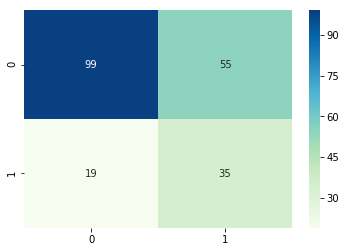

In [50]:
sns.heatmap(confusion_matrix(y_test, y_predicted_DTC), annot = True, fmt = '', cmap = "GnBu")

- 	Ensemble methods like Random Forest, Extremely Tree and Ada Boost Classifiers.  These methods “combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator ”.  The first two are in averaging methods, where independent estimators are used over random samples and resulting predictions are averaged, getting as result a lower variance than a single estimator.   

In [51]:
print ("Fitting the Random Forest Classifier to the training set")

param_grid = {
         'n_estimators' :[3,5,7,10],
         'max_depth': [2, 3, 4, 5, 6,7],
          #'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf_RFC = GridSearchCV(RandomForestClassifier(min_samples_split=2, random_state=123, class_weight='balanced'), 
                       param_grid, n_jobs=-1)

clf_RFC = clf_RFC.fit(X_train, y_train)

scores_RFC = cross_val_score(clf_RFC, X_train, y_train, cv=4, n_jobs=-1)
print(scores_RFC)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_RFC.mean(), scores_RFC.std() * 2))

print ("Best estimator found by grid search:")
print (clf_RFC.best_estimator_)
y_predicted_RFC = clf_RFC.predict(X_test)

print (metrics.classification_report(y_test, y_predicted_RFC))
process = time.process_time()
print (process)

Fitting the Random Forest Classifier to the training set
[ 0.69230769  0.67096774  0.66451613  0.61935484]
Accuracy: 0.6618 (+/- 0.0531)
Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.79      0.75      0.77       154
          1       0.38      0.44      0.41        54

avg / total       0.69      0.67      0.68       208

411.296875


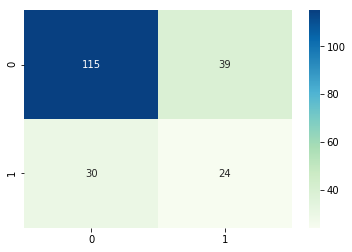

In [52]:
sns.heatmap(confusion_matrix(y_test, y_predicted_RFC), annot = True, fmt = '', cmap = "GnBu")

In [53]:
print ("Fitting the Extremely Tree Classifier to the training set")

param_grid = {
         'n_estimators' :[3,5,10],
         'max_depth': [2, 3, 4, 5, 6,7],
          #'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf_EFC = GridSearchCV(ExtraTreesClassifier(min_samples_split=2, random_state=123, class_weight='balanced'), 
                       param_grid, n_jobs=-1)

clf_EFC = clf_EFC.fit(X_train, y_train)

scores_EFC = cross_val_score(clf_EFC, X_train, y_train, cv=4, n_jobs=-1)
print(scores_EFC)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_EFC.mean(), scores_EFC.std() * 2))

print ("Best estimator found by grid search:")
print (clf_EFC.best_estimator_)
y_predicted_EFC = clf_EFC.predict(X_test)

print (metrics.classification_report(y_test, y_predicted_EFC))
process = time.process_time()
print (process)

Fitting the Extremely Tree Classifier to the training set
[ 0.72435897  0.67741935  0.63870968  0.64516129]
Accuracy: 0.6714 (+/- 0.0678)
Best estimator found by grid search:
ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=5, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.83      0.81      0.82       154
          1       0.48      0.52      0.50        54

avg / total       0.74      0.73      0.73       208

412.1875


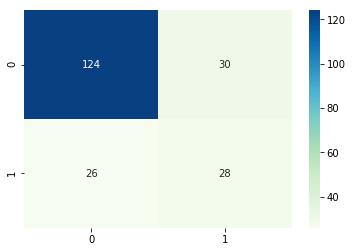

In [54]:
sns.heatmap(confusion_matrix(y_test, y_predicted_EFC), annot = True, fmt = '', cmap = "GnBu")

In [55]:
print ("Fitting the Ada Boost Classifier to the training set")

param_grid = {
         'n_estimators' :[3,5,10],
         'learning_rate': [0.01],
         #'max_depth': [2, 3, 4, 5, 6,7],
          #'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf_ABC = GridSearchCV(AdaBoostClassifier(random_state=123), param_grid, n_jobs=-1)

clf_ABC = clf_ABC.fit(X_train, y_train)

scores_ABC = cross_val_score(clf_ABC, X_train, y_train, cv=4, n_jobs=-1)
print(scores_ABC)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_ABC.mean(), scores_ABC.std() * 2))

print ("Best estimator found by grid search:")
print (clf_ABC.best_estimator_)
y_predicted_ABC = clf_ABC.predict(X_test)

print (metrics.classification_report(y_test, y_predicted_ABC))
process = time.process_time()
print (process)

Fitting the Ada Boost Classifier to the training set
[ 0.72435897  0.72258065  0.72258065  0.72258065]
Accuracy: 0.7230 (+/- 0.0015)
Best estimator found by grid search:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.01, n_estimators=3, random_state=123)
             precision    recall  f1-score   support

          0       0.74      1.00      0.85       154
          1       0.00      0.00      0.00        54

avg / total       0.55      0.74      0.63       208

412.765625


C:\Users\pc1\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


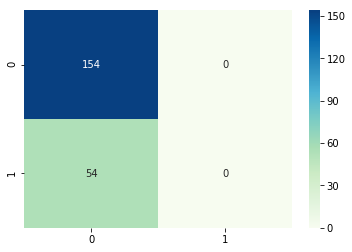

In [56]:
sns.heatmap(confusion_matrix(y_test, y_predicted_ABC), annot = True, fmt = '', cmap = "GnBu")

-	Logistic Regression Classifier is the most traditional method applied to classification problems.  Here a logistic probability function is applied to data, and the result obtained is a probability of occurrence of the binary categorical variable

In [57]:
print ("Fitting the Logistic Regression Classification - Hingue loss classifier to the training set")

param_grid = {
         'C': [1e-3, 1e-2, 1, 1e3, 5e3, 1e4, 5e4, 1e5],
          #'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf_LOGREG = GridSearchCV(LogisticRegression(random_state=123), param_grid, n_jobs=-1)
clf_LOGREG= clf_LOGREG .fit(X_train, y_train)

scores_LOGREG = cross_val_score(clf_LOGREG, X_train, y_train, cv=4, n_jobs=-1)
print(scores_LOGREG)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_LOGREG.mean(), scores_LOGREG.std() * 2))

print ("Best estimator found by grid search:")
print (clf_LOGREG.best_estimator_)

y_predicted_LOGREG = clf_LOGREG.predict(X_test)

print (metrics.classification_report(y_test, y_predicted_LOGREG))

process = time.process_time()
print (process)


Fitting the Logistic Regression Classification - Hingue loss classifier to the training set
[ 0.72435897  0.72258065  0.72258065  0.72258065]
Accuracy: 0.7230 (+/- 0.0015)
Best estimator found by grid search:
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.74      1.00      0.85       154
          1       0.00      0.00      0.00        54

avg / total       0.55      0.74      0.63       208

413.46875


C:\Users\pc1\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


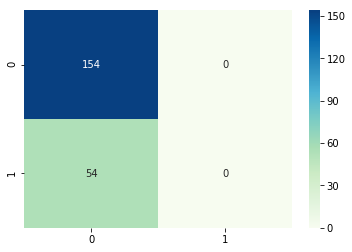

In [58]:
sns.heatmap(confusion_matrix(y_test, y_predicted_LOGREG), annot = True, fmt = '', cmap = "GnBu")

In [59]:
# Best Models

clf_RBF_b = SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
                decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
                max_iter=-1, probability=False, random_state=None, shrinking=True,
                tol=0.001, verbose=False)

y_predicted_RBF_b = clf_RBF_b.fit(X_train,y_train).predict(X_test)

clf_LSCV_b = LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
                       intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
                       penalty='l2', random_state=None, tol=0.0001, verbose=0)

y_predicted_LSCV_b = clf_LSCV_b.fit(X_train,y_train).predict(X_test)

clf_SIGMOID_b = SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=1,
                    decision_function_shape=None, degree=3, gamma=0.001, kernel='sigmoid',
                    max_iter=-1, probability=False, random_state=None, shrinking=True,
                    tol=0.001, verbose=False)

y_predicted_SIGMOID_b = clf_SIGMOID_b.fit(X_train,y_train).predict(X_test)

clf_DTC_b = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                                   max_depth=7, max_features=None, max_leaf_nodes=None,
                                   min_impurity_split=1e-07, min_samples_leaf=1,
                                   min_samples_split=2, min_weight_fraction_leaf=0.0,
                                   presort=False, random_state=123, splitter='best')

y_predicted_DTC_b = clf_DTC_b.fit(X_train,y_train).predict(X_test)

clf_RFC_b = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                   criterion='gini', max_depth=7, max_features='auto',
                                   max_leaf_nodes=None, min_impurity_split=1e-07,
                                   min_samples_leaf=1, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                                   oob_score=False, random_state=123, verbose=0, warm_start=False)

y_predicted_RFC_b = clf_RFC_b.fit(X_train,y_train).predict(X_test)

clf_EFC_b = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
                                 criterion='gini', max_depth=5, max_features='auto',
                                 max_leaf_nodes=None, min_impurity_split=1e-07,
                                 min_samples_leaf=1, min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                                 oob_score=False, random_state=123, verbose=0, warm_start=False)

y_predicted_EFC_b = clf_EFC_b.fit(X_train,y_train).predict(X_test)

clf_ABC_b = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                               learning_rate=0.01, n_estimators=3, random_state=123)

y_predicted_ABC_b = clf_ABC_b.fit(X_train,y_train).predict(X_test)


clf_LR_b= LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                             penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
                             verbose=0, warm_start=False)

y_predicted_LR_b = clf_LR_b.fit(X_train,y_train).predict(X_test)

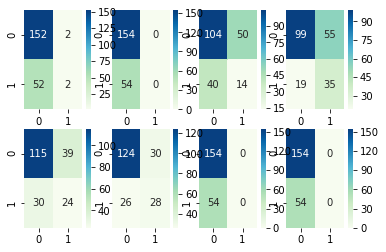

In [60]:
fig, axes = plt.subplots(2,4)

sns.heatmap(confusion_matrix(y_test, y_predicted_RBF_b), annot = True, fmt = '', cmap = "GnBu", ax=axes[0, 0])
sns.heatmap(confusion_matrix(y_test, y_predicted_LSCV_b), annot = True, fmt = '', cmap = "GnBu", ax=axes[0, 1])
sns.heatmap(confusion_matrix(y_test, y_predicted_SIGMOID_b), annot = True, fmt = '', cmap = "GnBu", ax=axes[0, 2])
sns.heatmap(confusion_matrix(y_test, y_predicted_DTC_b), annot = True, fmt = '', cmap = "GnBu", ax=axes[0, 3])
sns.heatmap(confusion_matrix(y_test, y_predicted_RFC_b), annot = True, fmt = '', cmap = "GnBu", ax=axes[1, 0])
sns.heatmap(confusion_matrix(y_test, y_predicted_EFC_b), annot = True, fmt = '', cmap = "GnBu", ax=axes[1, 1])
sns.heatmap(confusion_matrix(y_test, y_predicted_ABC_b), annot = True, fmt = '', cmap = "GnBu", ax=axes[1, 2])
sns.heatmap(confusion_matrix(y_test, y_predicted_LR_b), annot = True, fmt = '', cmap = "GnBu", ax=axes[1, 3])

# Ensemble voting classifier

-  All models, this is not a good option, it inherits all the problems of models that do not run well 

In [61]:
eclf1 = VotingClassifier(estimators=[
    ('rbf',clf_RBF_b), ('LSCV',clf_LSCV_b),
    ('sigmoid',clf_SIGMOID_b), ('DTC',clf_DTC_b),
    ('RFC',clf_RFC_b),('EFC',clf_EFC_b),
    ('ABC',clf_ABC_b), ('svc',clf_LR_b)], 
                         voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
y_predict_eclf1 =  eclf1.predict(X_test)

print (eclf1.get_params(deep=True))
print (eclf1.score(X_train, y_train, sample_weight=None))

{'svc__dual': False, 'DTC': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=123, splitter='best'), 'LSCV__penalty': 'l2', 'RFC__n_estimators': 10, 'EFC__n_estimators': 10, 'EFC__class_weight': 'balanced', 'RFC__max_depth': 7, 'sigmoid__decision_function_shape': None, 'sigmoid__probability': False, 'rbf__verbose': False, 'sigmoid__random_state': None, 'sigmoid__cache_size': 200, 'rbf__C': 1, 'rbf__tol': 0.001, 'DTC__splitter': 'best', 'ABC__base_estimator': None, 'LSCV__max_iter': 1000, 'svc__random_state': 123, 'sigmoid__tol': 0.001, 'rbf__decision_function_shape': None, 'rbf__coef0': 0.0, 'DTC__min_samples_leaf': 1, 'svc__intercept_scaling': 1, 'svc__penalty': 'l2', 'LSCV': LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,


In [62]:
eclf2 = VotingClassifier(estimators=[
    ('rbf',clf_RBF), ('LSCV',clf_LSCV),
    ('sigmoid',clf_SIGMOID), ('DTC',clf_DTC),
    ('RFC',clf_RFC),('EFC',clf_EFC),
    ('ABC',clf_ABC), ('svc',clf_LOGREG)], 
                         voting='hard')
eclf2 = eclf2.fit(X_train, y_train)
y_predict_eclf2 =  eclf2.predict(X_test)

print (eclf2.get_params(deep=True))
print (eclf2.score(X_train, y_train, sample_weight=None))

#Basically does the same that chose the best models, this function uses the best models too

{'rbf__scoring': None, 'DTC__estimator__splitter': 'best', 'svc__estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'rbf__estimator__verbose': False, 'LSCV__estimator__verbose': 0, 'LSCV__estimator__tol': 0.0001, 'DTC__estimator__max_leaf_nodes': None, 'DTC__estimator__max_features': None, 'rbf__estimator': SVC(C=1.0, cache_size=1000, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'sigmoid__refit': True, 'svc__estimator__multi_class': 'ovr', 'LSCV__estimator__multi_class': 'ovr', 'sigmoid__scoring': None, 'RFC__pre_dispatch': '2*n_jobs', 'rbf__estimator__gamma': 'auto', 'RFC__estimator__warm_start': False, 'RF

0.766505636071


In [63]:
# Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[152   2]
 [ 52   2]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.96  0.04]]


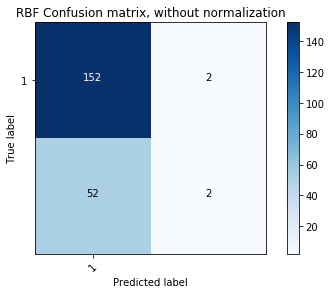

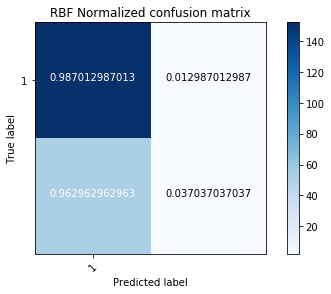

In [64]:
cnf_matrix_RBF = confusion_matrix(y_test, y_predicted_RBF_b)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_RBF, classes= '1',
                      title='RBF Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_RBF, classes='1', normalize=True,
                      title='RBF Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[154   0]
 [ 54   0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


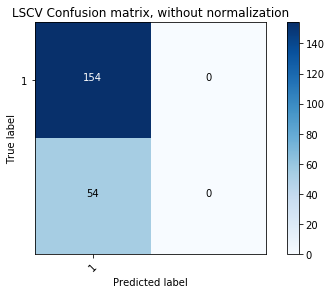

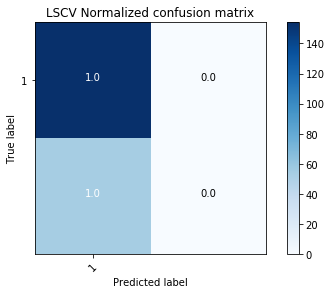

In [65]:
cnf_matrix_LSCV = confusion_matrix(y_test, y_predicted_LSCV_b)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LSCV, classes='1',
                      title='LSCV Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LSCV, classes='1', normalize=True,
                      title='LSCV Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[104  50]
 [ 40  14]]
Normalized confusion matrix
[[ 0.68  0.32]
 [ 0.74  0.26]]


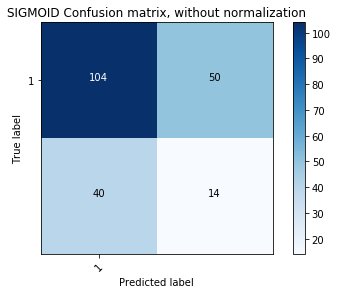

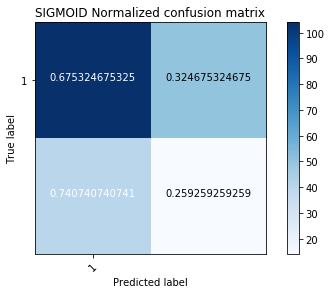

In [66]:
cnf_matrix_SIGMOID = confusion_matrix(y_test, y_predicted_SIGMOID_b)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_SIGMOID, classes='1',
                      title='SIGMOID Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_SIGMOID, classes='1', normalize=True,
                      title='SIGMOID Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[99 55]
 [19 35]]
Normalized confusion matrix
[[ 0.64  0.36]
 [ 0.35  0.65]]


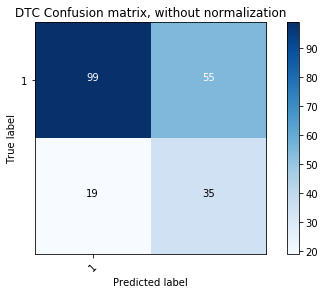

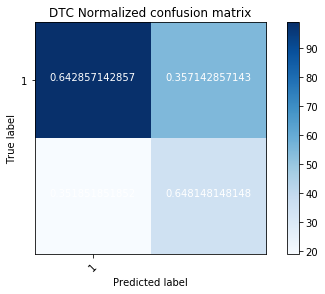

In [67]:
cnf_matrix_DTC = confusion_matrix(y_test, y_predicted_DTC_b)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_DTC, classes='1',
                      title='DTC Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_DTC, classes='1', normalize=True,
                      title='DTC Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[115  39]
 [ 30  24]]
Normalized confusion matrix
[[ 0.75  0.25]
 [ 0.56  0.44]]


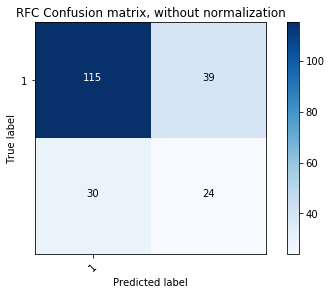

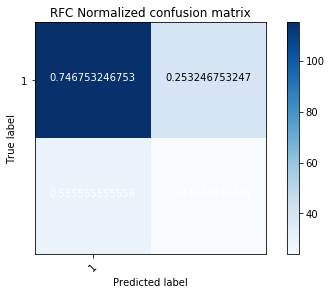

In [68]:
cnf_matrix_RFC = confusion_matrix(y_test, y_predicted_RFC_b)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_RFC, classes='1',
                      title='RFC Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_RFC, classes='1', normalize=True,
                      title='RFC Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[124  30]
 [ 26  28]]
Normalized confusion matrix
[[ 0.81  0.19]
 [ 0.48  0.52]]


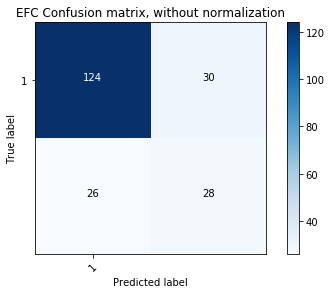

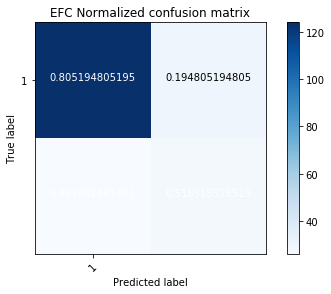

In [69]:
cnf_matrix_EFC = confusion_matrix(y_test, y_predicted_EFC_b)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_EFC, classes='1',
                      title='EFC Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_EFC, classes='1', normalize=True,
                      title='EFC Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[154   0]
 [ 54   0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


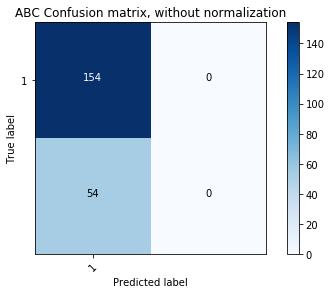

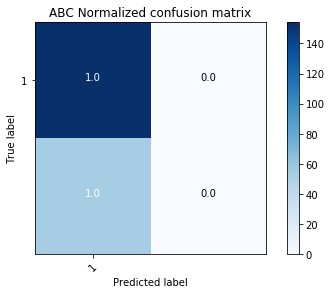

In [70]:
cnf_matrix_ABC = confusion_matrix(y_test, y_predicted_ABC_b)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_ABC, classes='1',
                      title='ABC Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_ABC, classes='1', normalize=True,
                      title='ABC Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[154   0]
 [ 54   0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


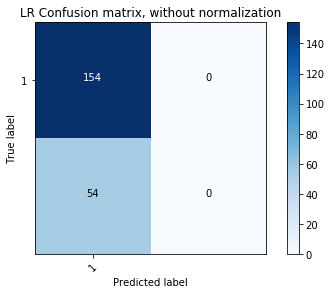

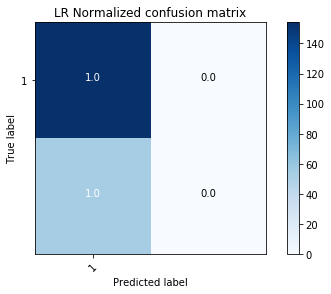

In [71]:
cnf_matrix_LR = confusion_matrix(y_test, y_predicted_LR_b)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LR, classes='1',
                      title='LR Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LR, classes='1', normalize=True,
                      title='LR Normalized confusion matrix')

plt.show()

The following ensemble model only aggregate five models:

In [72]:
eclf3 = VotingClassifier(estimators=[
    ('rbf',clf_RBF), ('sigmoid',clf_SIGMOID), ('DTC',clf_DTC),
    ('RFC',clf_RFC),('EFC',clf_EFC)], 
                         voting='hard')
eclf3 = eclf3.fit(X_train, y_train)
y_predict_eclf3 =  eclf3.predict(X_test)

print (eclf3.get_params(deep=True))
print (eclf3.score(X_train, y_train, sample_weight=None))

{'rbf__refit': True, 'EFC__iid': True, 'DTC': GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=123, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0), 'DTC__estimator__splitter': 'best', 'rbf__estimator__cache_size': 1000, 'rbf__estimator__kernel': 'rbf', 'DTC__estimator__max_leaf_nodes': None, 'DTC__estimator__max_features': None, 'rbf__estimator': SVC(C=1.0, cache_size=1000, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random

0.92270531401


In [73]:
print(y_predict_eclf3)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0
 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0]


In [74]:
scores_eclf3 = cross_val_score(eclf3 , X_train, y_train, cv=4, n_jobs=-1)
print(scores_eclf3 )
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_eclf3.mean(), scores_eclf3.std() * 2))

print (metrics.classification_report(y_test, y_predict_eclf3))

[ 0.74  0.74  0.67  0.71]
Accuracy: 0.7149 (+/- 0.0564)
             precision    recall  f1-score   support

          0       0.81      0.88      0.84       154
          1       0.55      0.43      0.48        54

avg / total       0.74      0.76      0.75       208



Confusion matrix, without normalization
[[135  19]
 [ 31  23]]
Normalized confusion matrix
[[ 0.88  0.12]
 [ 0.57  0.43]]


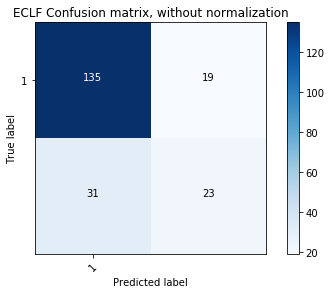

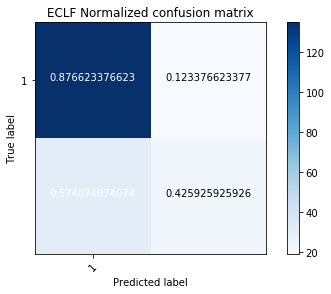

In [75]:
cnf_matrix_eclf3 = confusion_matrix(y_test, y_predict_eclf3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_eclf3, classes='1',
                      title='ECLF Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_eclf3, classes='1', normalize=True,
                      title='ECLF Normalized confusion matrix')

plt.show()

This ensemble voting model aggregates decision tree and the extremely tree models:

In [76]:
eclf4 = VotingClassifier(estimators=[
    ('DTC',clf_DTC), ('EFC',clf_EFC)], 
                         voting='hard')
eclf4 = eclf4.fit(X_train, y_train)
y_predict_eclf4 =  eclf4.predict(X_test)

print (eclf4.get_params(deep=True))
print (eclf4.score(X_train, y_train, sample_weight=None))

{'DTC__return_train_score': True, 'EFC__iid': True, 'DTC': GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=123, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0), 'EFC__estimator__min_samples_leaf': 1, 'DTC__estimator__splitter': 'best', 'DTC__estimator__min_weight_fraction_leaf': 0.0, 'DTC__estimator__criterion': 'entropy', 'EFC__refit': True, 'DTC__estimator__max_leaf_nodes': None, 'DTC__estimator__max_features': None, 'EFC__estimator__min_weight_fraction_leaf': 0.0, 'EFC__estimator__random_state': 123, 'EFC__estimato

In [77]:
scores_eclf4 = cross_val_score(eclf4 , X_train, y_train, cv=4, n_jobs=-1)
print(scores_eclf4 )
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_eclf4.mean(), scores_eclf4.std() * 2))

print (metrics.classification_report(y_test, y_predict_eclf4))

[ 0.74  0.72  0.67  0.72]
Accuracy: 0.7133 (+/- 0.0529)
             precision    recall  f1-score   support

          0       0.82      0.86      0.84       154
          1       0.54      0.48      0.51        54

avg / total       0.75      0.76      0.75       208



Confusion matrix, without normalization
[[132  22]
 [ 28  26]]
Normalized confusion matrix
[[ 0.86  0.14]
 [ 0.52  0.48]]


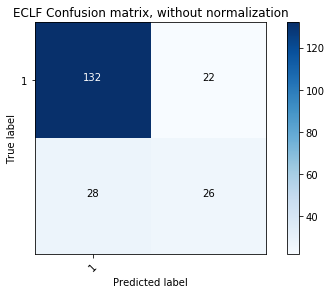

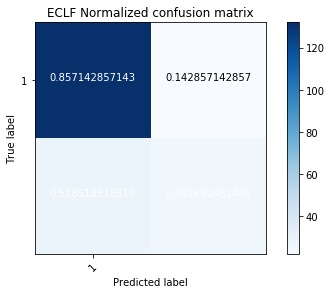

In [78]:
cnf_matrix_eclf4 = confusion_matrix(y_test, y_predict_eclf4)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_eclf4, classes='1',
                      title='ECLF Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_eclf4, classes='1', normalize=True,
                      title='ECLF Normalized confusion matrix')

plt.show()

The best model found here is the ensemble model with the decision tree and the extremely tree, even though the ensemble model with five aggregate methods shows a slightly better score, applying the principle of Occam's razor make the simplest better.  At this time, the resulting model can accurately predict the deaths given a series of medical examinations, as proposed in the hypothesis. While accuracy is not the best (76%), I think it may be a good start for future investigations of interdisciplinary teams in ICU forecasting diseases. 

From the forest model is possible to find how features weights in the results, such weights are called importance.  As you can see only 129 features are important to the model, the rest has no weights.  As you can expect, the antibiotic sensitivity are the most important feature (together weights 57% of importance) and AMIKACIN antibiotic the most important feature of the sample.  Every feature from age group weight 0.97% in average, followed by category feature which everyone weights less than 1%.

Feature ranking:
1. feature 240 (0.053948)
2. feature 273 (0.034461)
3. feature 237 (0.030208)
4. feature 427 (0.029493)
5. feature 416 (0.029326)
6. feature 37 (0.027816)
7. feature 517 (0.025309)
8. feature 118 (0.024947)
9. feature 16 (0.023853)
10. feature 658 (0.020297)
11. feature 186 (0.019731)
12. feature 480 (0.019372)
13. feature 488 (0.016219)
14. feature 588 (0.015917)
15. feature 414 (0.015770)
16. feature 29 (0.015359)
17. feature 470 (0.015139)
18. feature 293 (0.014874)
19. feature 238 (0.014657)
20. feature 187 (0.014469)
21. feature 197 (0.014247)
22. feature 223 (0.014117)
23. feature 23 (0.013355)
24. feature 523 (0.013277)
25. feature 259 (0.012357)
26. feature 98 (0.011632)
27. feature 128 (0.011117)
28. feature 6 (0.010978)
29. feature 123 (0.010387)
30. feature 359 (0.010151)
31. feature 243 (0.009812)
32. feature 563 (0.009535)
33. feature 713 (0.009299)
34. feature 566 (0.008907)
35. feature 508 (0.008858)
36. feature 546 (0.008840)
37. feature 328 (0.008714)


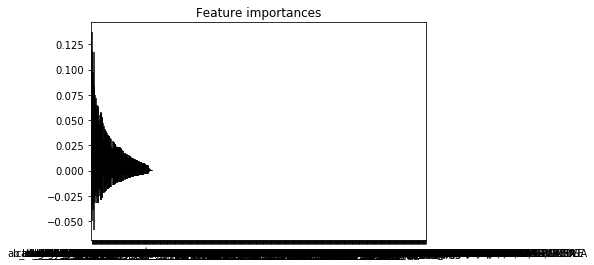

In [88]:
# Code source:  http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.datasets import make_classification
forest = clf_EFC_b

forest.fit(X_train, y_train)
feature_names = X_train.columns
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    if importances[indices[f]]>0:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


#plt.xticks(range(heart_train.shape[1]), )        
        
        
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [108]:
from sklearn.datasets import make_classification
forest = clf_EFC_b

forest.fit(X_train, y_train)
feature_names = X_train.columns
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


impor = []
for f in range(X_train.shape[1]):
    if importances[indices[f]]>0:
        impor.append({'Feature': feature_names[f] , 'Importance': importances[indices[f]]})

        

feature_importance = pd.DataFrame(impor).sort_values('Importance',ascending = False)
print(feature_importance.to_string())

                                               Feature  Importance
0                                     ab_name_AMIKACIN    0.053948
1                                   ab_name_AMPICILLIN    0.034461
2                         ab_name_AMPICILLIN/SULBACTAM    0.030208
3                                    ab_name_CEFAZOLIN    0.029493
4                                     ab_name_CEFEPIME    0.029326
5                                  ab_name_CEFTAZIDIME    0.027816
6                                  ab_name_CEFTRIAXONE    0.025309
7                                   ab_name_CEFUROXIME    0.024947
8                              ab_name_CHLORAMPHENICOL    0.023853
9                                ab_name_CIPROFLOXACIN    0.020297
10                                 ab_name_CLINDAMYCIN    0.019731
11                                  ab_name_DAPTOMYCIN    0.019372
12                                ab_name_ERYTHROMYCIN    0.016219
13                                  ab_name_GENTAMICIN    0.01

In [103]:
feature_importance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 2 columns):
Feature       129 non-null object
Importance    129 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.1+ KB


In [105]:
feature_importance['Importance'].sum()

1.0

In [122]:
#surveys_df[surveys_df.year == 2002]
more_important= feature_importance[feature_importance.Importance >= 0.009]
more_important

,Feature,Importance
0,ab_name_AMIKACIN,0.053948
1,ab_name_AMPICILLIN,0.034461
2,ab_name_AMPICILLIN/SULBACTAM,0.030208
3,ab_name_CEFAZOLIN,0.029493
4,ab_name_CEFEPIME,0.029326
5,ab_name_CEFTAZIDIME,0.027816
6,ab_name_CEFTRIAXONE,0.025309
7,ab_name_CEFUROXIME,0.024947
8,ab_name_CHLORAMPHENICOL,0.023853
9,ab_name_CIPROFLOXACIN,0.020297


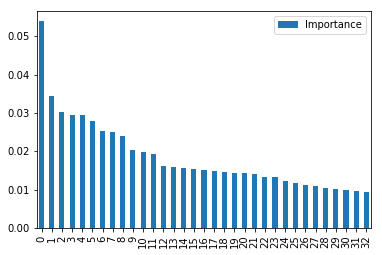

In [127]:
more_important.plot(kind='bar')